# Knowledge Quantification Score (KQS) - Weight Optimization using Expert Scores
This notebook performs optimization of weights used in computing the KQS metric using domain expert scores (HKQS).

In [1]:
# Install necessary libraries if not already installed
!pip install pandas openpyxl

In [2]:
import numpy as np
import pandas as pd

## Step 1: Load KQS Scores and Human Expert Scores

In [4]:
# Load computed KQS values
kqs_df = pd.read_excel("/content/KQS_Batch_Results.xlsx")
kqs_df.rename(columns=lambda x: x.strip(), inplace=True)

# Load human expert scores
hkqs_df = pd.read_csv("/content/HKQS_Unique_Domain_Expert_Scores.csv")
hkqs_df.rename(columns=lambda x: x.strip(), inplace=True)

# Merge both DataFrames on Lecture_File
merged_df = pd.merge(kqs_df, hkqs_df, on="Lecture_File")
merged_df.head()

Lecture_File  Semantic_Score  KG_Score  Mutual_Info  Observed_KQS_Score  \
0    lecture1.txt          0.6715    0.0556       0.7545            0.488928   
1   lecture10.txt          0.6498    0.0667       0.7173            0.473154   
2  lecture100.txt          0.8007    0.1250       0.7339            0.547668   
3   lecture11.txt          0.7379    0.1176       0.7299            0.523182   
4   lecture12.txt          0.7521    0.0588       0.7629            0.519354   

   Final_KQS  HKQS  HumanExpert_Score(HKQS)  
0   0.659927  0.68                     0.68  
1   0.634633  0.65                     0.65  
2   0.728017  0.75                     0.75  
3   0.691439  0.70                     0.70  
4   0.707673  0.75                     0.75

## Step 2: Prepare Training Data

In [5]:
# Feature matrix (Semantic Score, KG Score, MI Score)
X = merged_df[["Semantic_Score", "KG_Score", "Mutual_Info"]].values
# Target vector (HKQS)
Y = merged_df["HumanExpert_Score(HKQS)"].values

## Step 3: Adam Optimization Algorithm for Weight Tuning

In [6]:
# Initialize weights and parameters
w = np.array([1/3, 1/3, 1/3])
m = np.zeros(3)
v = np.zeros(3)
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
alpha = 0.01
epochs = 300

lecture_ids = merged_df["Lecture_File"].tolist()  # Make sure this list is available

# Initial prediction check
print("Initial predictions:", np.dot(X, w)[:5])
print("Ground truth HKQS:", Y[:5])

# Optimization loop with lecture-wise prediction and error reporting
for epoch in range(1, epochs + 1):
    preds = np.dot(X, w)
    error = preds - Y

    # Epoch-wise prediction and error display
    print(f"\nEpoch {epoch} Predictions and Errors:")
    for lec_id, pred, true_val, err in zip(lecture_ids, preds, Y, error):
        print(f"Lecture File: {lec_id}, Predicted KQS: {pred:.4f}, HKQS: {true_val:.4f}, Error: {err:.4f}")

    # Mean Squared Error (MSE)
    mse = np.mean(error ** 2)
    print(f"Epoch {epoch} MSE Loss: {mse:.6f}")

    # Adam optimizer update
    grad = 2 * np.dot(X.T, error) / len(Y)
    m = beta1 * m + (1 - beta1) * grad
    v = beta2 * v + (1 - beta2) * (grad ** 2)
    m_hat = m / (1 - beta1 ** epoch)
    v_hat = v / (1 - beta2 ** epoch)
    w -= alpha * m_hat / (np.sqrt(v_hat) + epsilon)

    # Project weights to ensure they are non-negative and sum to 1
    w = np.maximum(w, 0)
    w /= np.sum(w)

# Final weights after training
w1, w2, w3 = w
# Save Predicted vs. HKQS results to CSV
comparison_df = pd.DataFrame({
    "Lecture_File": lecture_ids,
    "Predicted_KQS": np.round(preds, 4),
    "HumanExpert_Score(HKQS)": np.round(Y, 4),
    "Error": np.round(preds - Y, 4)
})

# Export to CSV
comparison_df.to_csv("Predicted_vs_HKQS_Results.csv", index=False)
print("Predicted vs HKQS results saved to Predicted_vs_HKQS_Results.csv")

print(f"\nFinal Optimized Weights -> w1: {w1:.4f}, w2: {w2:.4f}, w3: {w3:.4f}")


Initial predictions: [0.49386667 0.47793333 0.5532     0.52846667 0.5246    ]
Ground truth HKQS: [0.68 0.65 0.75 0.7  0.75]

Epoch 1 Predictions and Errors:
Lecture File: lecture1.txt, Predicted KQS: 0.4939, HKQS: 0.6800, Error: -0.1861
Lecture File: lecture10.txt, Predicted KQS: 0.4779, HKQS: 0.6500, Error: -0.1721
Lecture File: lecture100.txt, Predicted KQS: 0.5532, HKQS: 0.7500, Error: -0.1968
Lecture File: lecture11.txt, Predicted KQS: 0.5285, HKQS: 0.7000, Error: -0.1715
Lecture File: lecture12.txt, Predicted KQS: 0.5246, HKQS: 0.7500, Error: -0.2254
Lecture File: lecture13.txt, Predicted KQS: 0.5110, HKQS: 0.7000, Error: -0.1890
Lecture File: lecture14.txt, Predicted KQS: 0.5399, HKQS: 0.7500, Error: -0.2101
Lecture File: lecture15.txt, Predicted KQS: 0.4880, HKQS: 0.7400, Error: -0.2520
Lecture File: lecture16.txt, Predicted KQS: 0.5032, HKQS: 0.7400, Error: -0.2368
Lecture File: lecture17.txt, Predicted KQS: 0.5309, HKQS: 0.8000, Error: -0.2691
Lecture File: lecture18.txt, Pred

In [7]:
import pandas as pd
df_check = pd.DataFrame(X, columns=["Semantic", "KG", "MI"])
df_check["HKQS"] = Y
print(df_check.corr())

          Semantic        KG        MI      HKQS
Semantic  1.000000  0.258676 -0.117209  0.528682
KG        0.258676  1.000000 -0.053137  0.226281
MI       -0.117209 -0.053137  1.000000  0.412910
HKQS      0.528682  0.226281  0.412910  1.000000


Initial Weights: [0.37454012 0.95071431 0.73199394]

Epoch 1 Predictions and Errors:
Lecture File: lecture1.txt, Predicted KQS: 0.4164, HKQS: 0.6800, Error: -0.2636
Lecture File: lecture10.txt, Predicted KQS: 0.4043, HKQS: 0.6500, Error: -0.2457
Lecture File: lecture100.txt, Predicted KQS: 0.4647, HKQS: 0.7500, Error: -0.2853
Lecture File: lecture11.txt, Predicted KQS: 0.4484, HKQS: 0.7000, Error: -0.2516
Lecture File: lecture12.txt, Predicted KQS: 0.4355, HKQS: 0.7500, Error: -0.3145
Lecture File: lecture13.txt, Predicted KQS: 0.4378, HKQS: 0.7000, Error: -0.2622
Lecture File: lecture14.txt, Predicted KQS: 0.4439, HKQS: 0.7500, Error: -0.3061
Lecture File: lecture15.txt, Predicted KQS: 0.3941, HKQS: 0.7400, Error: -0.3459
Lecture File: lecture16.txt, Predicted KQS: 0.4219, HKQS: 0.7400, Error: -0.3181
Lecture File: lecture17.txt, Predicted KQS: 0.4323, HKQS: 0.8000, Error: -0.3677
Lecture File: lecture18.txt, Predicted KQS: 0.4318, HKQS: 0.8000, Error: -0.3682
Lecture File: lecture19.

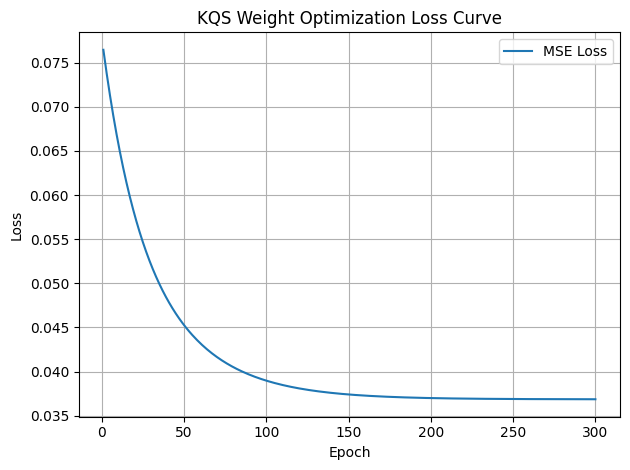

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load predicted KQS and HKQS (replace with correct paths)
predicted_df = pd.read_excel("KQS_Batch_Results.xlsx")
expert_df = pd.read_csv("/content/HKQS_Unique_Domain_Expert_Scores.csv")

# Drop duplicates and merge
expert_df = expert_df.drop_duplicates(subset="Lecture_File", keep="first")
merged_df = pd.merge(predicted_df, expert_df, on="Lecture_File")

# Input features and target
X = merged_df[["Semantic_Score", "KG_Score", "Mutual_Info"]].values
Y = merged_df["HumanExpert_Score(HKQS)"].values
lecture_ids = merged_df["Lecture_File"].tolist()

# Initialize weights and optimizer settings
np.random.seed(42)
w = np.random.rand(3)
print("Initial Weights:", w)
w /= np.sum(w)
m = np.zeros(3)
v = np.zeros(3)
beta1, beta2 = 0.9, 0.999
epsilon, alpha = 1e-8, 0.01
epochs = 300
losses = []

# Optimization loop
for epoch in range(1, epochs + 1):
    preds = np.dot(X, w)
    error = preds - Y
    mse = np.mean(error ** 2)
    losses.append(mse)

    if epoch in [1, 100, 200, 300]:
        print(f"\nEpoch {epoch} Predictions and Errors:")
        for lec_id, pred, true_val, err in zip(lecture_ids, preds, Y, error):
            print(f"Lecture File: {lec_id}, Predicted KQS: {pred:.4f}, HKQS: {true_val:.4f}, Error: {err:.4f}")
        print(f"Epoch {epoch} MSE Loss: {mse:.6f}")

    grad = 2 * np.dot(X.T, error) / len(Y)
    m = beta1 * m + (1 - beta1) * grad
    v = beta2 * v + (1 - beta2) * (grad ** 2)
    m_hat = m / (1 - beta1 ** epoch)
    v_hat = v / (1 - beta2 ** epoch)
    w -= alpha * m_hat / (np.sqrt(v_hat) + epsilon)
    w = np.maximum(w, 0)
    w /= np.sum(w)

# Final weights
w1, w2, w3 = w
print(f"\nFinal Optimized Weights -> w1: {w1:.4f}, w2: {w2:.4f}, w3: {w3:.4f}")

# Plot loss curve
plt.plot(range(1, epochs + 1), losses, label="MSE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("KQS Weight Optimization Loss Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#with Graphs

Initial Weights (before normalization): [0.37454012 0.95071431 0.73199394]
Initial Weights (normalized): [0.18205878 0.46212909 0.35581214]

Epoch 1 Predictions and Errors:
Lecture File: lecture1.txt, Predicted KQS: 0.4166, HKQS: 0.6800, Error: -0.2634
Lecture File: lecture10.txt, Predicted KQS: 0.4069, HKQS: 0.6500, Error: -0.2431
Lecture File: lecture100.txt, Predicted KQS: 0.4655, HKQS: 0.7500, Error: -0.2845
Lecture File: lecture11.txt, Predicted KQS: 0.4499, HKQS: 0.7000, Error: -0.2501
Lecture File: lecture12.txt, Predicted KQS: 0.4347, HKQS: 0.7500, Error: -0.3153
Lecture File: lecture13.txt, Predicted KQS: 0.4401, HKQS: 0.7000, Error: -0.2599
Lecture File: lecture14.txt, Predicted KQS: 0.4474, HKQS: 0.7500, Error: -0.3026
Lecture File: lecture15.txt, Predicted KQS: 0.4065, HKQS: 0.7000, Error: -0.2935
Lecture File: lecture16.txt, Predicted KQS: 0.4231, HKQS: 0.7000, Error: -0.2769
Lecture File: lecture17.txt, Predicted KQS: 0.4324, HKQS: 0.7000, Error: -0.2676
Lecture File: lec

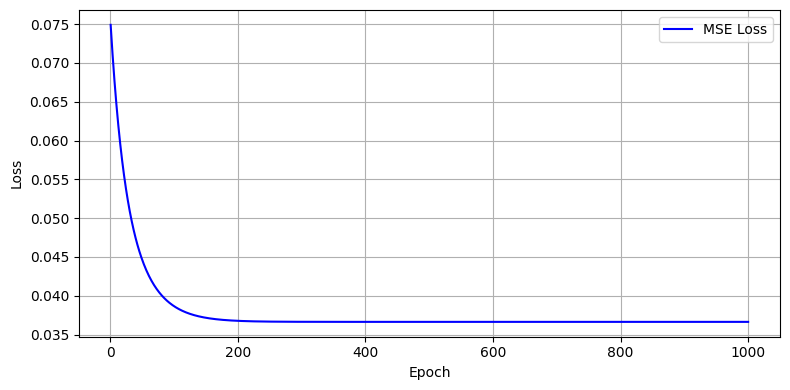

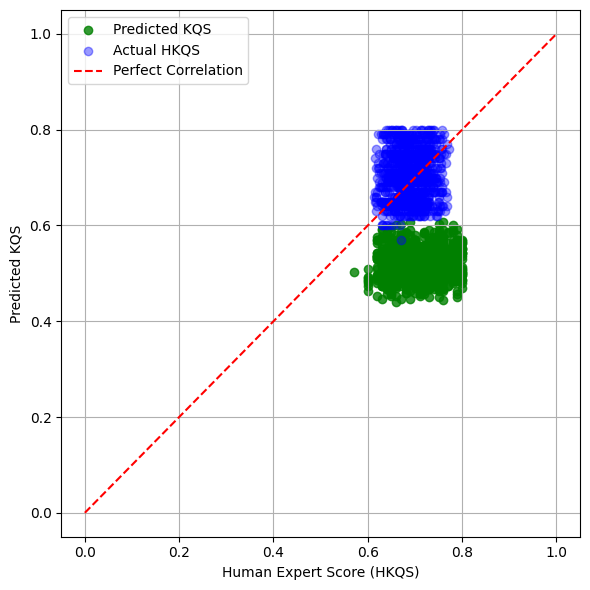

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load predicted KQS and HKQS
predicted_df = pd.read_csv("lectures_1000.csv")
predicted_df.head(5);
# Input features and target

X =predicted_df[["Semantic_Score", "KG_Score", "Mutual_Info"]].values
Y = predicted_df["HKQS"].values
lecture_ids = predicted_df["Lecture_File"].tolist()

# Initialize weights and optimizer settings
np.random.seed(42)
w = np.random.rand(3)
print("Initial Weights (before normalization):", w)
w /= np.sum(w)
print("Initial Weights (normalized):", w)

m = np.zeros(3)
v = np.zeros(3)
beta1, beta2 = 0.9, 0.999
epsilon, alpha = 1e-8, 0.01
epochs = 1000
losses = []

# Optimization loop
for epoch in range(1, epochs + 1):
    preds = np.dot(X, w)
    error = preds - Y
    mse = np.mean(error ** 2)
    losses.append(mse)

    if epoch in [1, 100, 200, 300]:
        print(f"\nEpoch {epoch} Predictions and Errors:")
        for lec_id, pred, true_val, err in zip(lecture_ids, preds, Y, error):
            print(f"Lecture File: {lec_id}, Predicted KQS: {pred:.4f}, HKQS: {true_val:.4f}, Error: {err:.4f}")
        print(f"Epoch {epoch} MSE Loss: {mse:.6f}")

    grad = 2 * np.dot(X.T, error) / len(Y)
    m = beta1 * m + (1 - beta1) * grad
    v = beta2 * v + (1 - beta2) * (grad ** 2)
    m_hat = m / (1 - beta1 ** epoch)
    v_hat = v / (1 - beta2 ** epoch)
    w -= alpha * m_hat / (np.sqrt(v_hat) + epsilon)
    w = np.maximum(w, 0)
    w /= np.sum(w)

# Final weights
w1, w2, w3 = w
print(f"\nFinal Optimized Weights -> w1: {w1:.4f}, w2: {w2:.4f}, w3: {w3:.4f}")

# Plot 1: Loss curve
plt.figure(figsize=(8, 4))
plt.plot(range(1, epochs + 1), losses, label="MSE Loss", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.title("KQS Weight Optimization Loss Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Predicted KQS vs. HKQS
plt.figure(figsize=(6, 6))
plt.scatter(Y, preds, alpha=0.8, color='green', label='Predicted KQS')
# Actual HKQS (blue, on y = x line)
plt.scatter(predicted_df["Final_KQS"].values, predicted_df["HKQS"].values, alpha=0.4, color='blue', label='Actual HKQS')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Correlation')
plt.xlabel("Human Expert Score (HKQS)")
plt.ylabel("Predicted KQS")
#plt.title("Predicted KQS vs. Human Expert Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#new maths power mean :UPDATED CODE (NEW MATHS, SAME DATASET & GRAPHS) 1000Lecture

Initial θ: [ 0.49671415 -0.1382643   0.64768854]
Initial weights (softmax): [0.37134498 0.19679312 0.4318619 ]

Epoch 1
Weights: [0.37134498 0.19679312 0.4318619 ]
MSE: 0.005113912563086697

Epoch 100
Weights: [0.37437023 0.18582395 0.43980582]
MSE: 0.004773345638363175

Epoch 300
Weights: [0.37758183 0.16909078 0.45332738]
MSE: 0.00432743304796041

Final Optimized Weights:
w1 (PAS): 0.3744, w2 (JI): 0.1373, w3 (MI): 0.4883


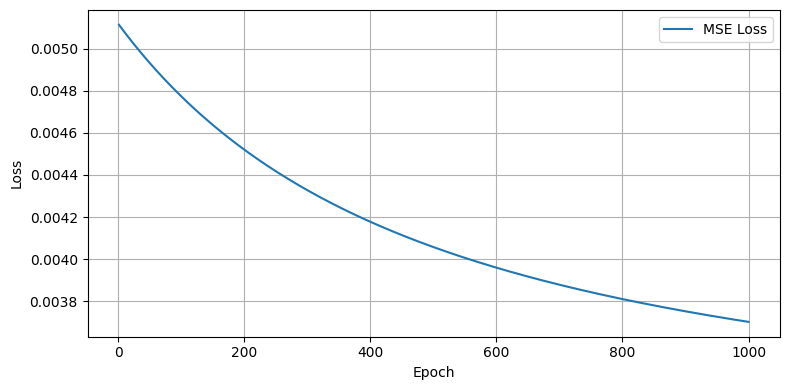

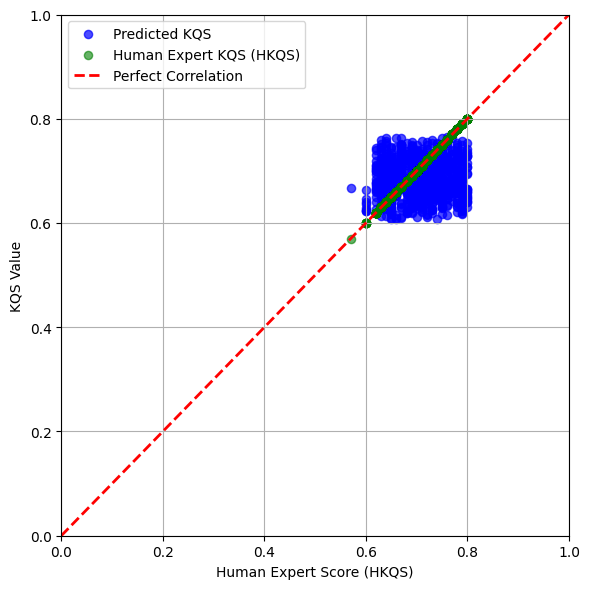

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# Load data
# -------------------------------------------------
df = pd.read_csv("lectures_1000.csv")

X = df[["Semantic_Score", "KG_Score", "Mutual_Info"]].values
Y = df["HKQS"].values
lecture_ids = df["Lecture_File"].tolist()
N = len(Y)

# -------------------------------------------------
# Power Mean exponent
# -------------------------------------------------
p = 2  # validated best value

# -------------------------------------------------
# Softmax function
# -------------------------------------------------
def softmax(theta):
    exp_theta = np.exp(theta - np.max(theta))
    return exp_theta / np.sum(exp_theta)

# -------------------------------------------------
# Initialize parameters (θ)
# -------------------------------------------------
np.random.seed(42)
theta = np.random.randn(3)
alpha = 0.05
epochs = 1000
losses = []

print("Initial θ:", theta)
print("Initial weights (softmax):", softmax(theta))

# -------------------------------------------------
# Optimization loop
# -------------------------------------------------
for epoch in range(1, epochs + 1):

    # Compute convex weights
    w = softmax(theta)

    # Power Mean KQS prediction
    preds = (
        w[0] * (X[:, 0] ** p) +
        w[1] * (X[:, 1] ** p) +
        w[2] * (X[:, 2] ** p)
    ) ** (1 / p)

    error = preds - Y
    mse = np.mean(error ** 2)
    losses.append(mse)

    # Gradient w.r.t weights
    grad_w = np.zeros(3)
    for j in range(3):
        grad_w[j] = (2 / N) * np.sum(
            error * (X[:, j] ** p) / (preds ** (p - 1) + 1e-8)
        )

    # Jacobian of softmax
    w_col = w.reshape(-1, 1)
    softmax_jacobian = np.diagflat(w) - w_col @ w_col.T

    # Gradient w.r.t theta
    grad_theta = softmax_jacobian @ grad_w

    # Gradient update
    theta -= alpha * grad_theta

    # Debug prints
    if epoch in [1, 100, 300]:
        print(f"\nEpoch {epoch}")
        print("Weights:", w)
        print("MSE:", mse)

# -------------------------------------------------
# Final weights
# -------------------------------------------------
final_w = softmax(theta)
print("\nFinal Optimized Weights:")
print(f"w1 (PAS): {final_w[0]:.4f}, w2 (JI): {final_w[1]:.4f}, w3 (MI): {final_w[2]:.4f}")

# -------------------------------------------------
# Plot 1: Loss Curve
# -------------------------------------------------
plt.figure(figsize=(8, 4))
plt.plot(range(1, epochs + 1), losses, label="MSE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------------------------
# Plot: HKQS & Predicted KQS on same 0–1 scale
# -------------------------------------------------
plt.figure(figsize=(6, 6))

# Predicted KQS vs HKQS
plt.scatter(Y, preds, color='blue', alpha=0.7, s=35, label="Predicted KQS")

# HKQS vs HKQS (shown as green dots on diagonal)
plt.scatter(Y, Y, color='green', alpha=0.6, s=35, label="Human Expert KQS (HKQS)")

# Perfect correlation line y = x
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label="Perfect Correlation")

# Force axis scale to [0, 1]
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("Human Expert Score (HKQS)")
plt.ylabel("KQS Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




#6000 Dataset New Math

Initial θ: [ 0.49671415 -0.1382643   0.64768854]
Initial weights (softmax): [0.37134498 0.19679312 0.4318619 ]

Epoch 1
Weights: [0.37134498 0.19679312 0.4318619 ]
MSE: 0.005490856722342325

Epoch 100
Weights: [0.37371203 0.19072928 0.43555869]
MSE: 0.00538953360095336

Epoch 300
Weights: [0.37705762 0.18044381 0.44249857]
MSE: 0.0052347495356184414

Final Optimized Weights:
w1 (PAS): 0.3793, w2 (JI): 0.1567, w3 (MI): 0.4640


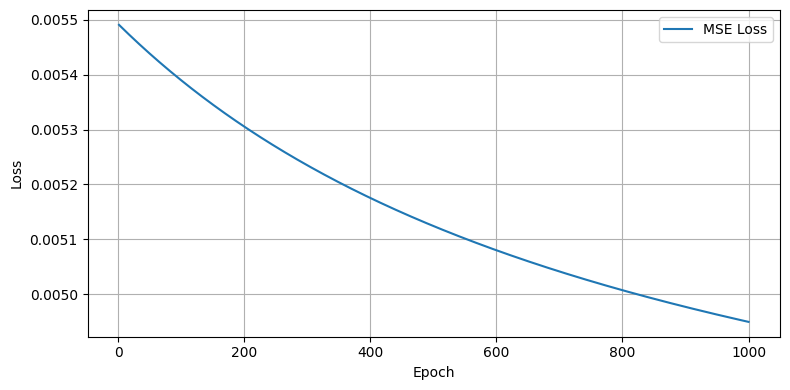

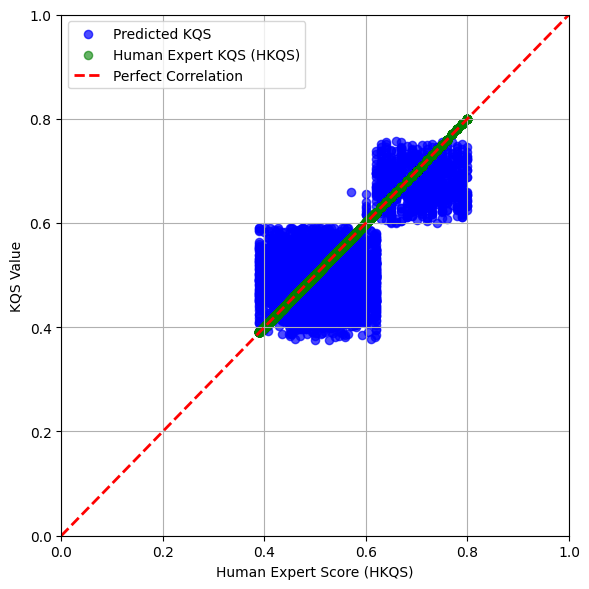

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# Load data
# -------------------------------------------------
df = pd.read_csv("lectures_45000.csv")

X = df[["Semantic_Score", "KG_Score", "Mutual_Info"]].values
Y = df["HKQS"].values
lecture_ids = df["Lecture_File"].tolist()
N = len(Y)

# -------------------------------------------------
# Power Mean exponent
# -------------------------------------------------
p = 2  # validated best value

# -------------------------------------------------
# Softmax function
# -------------------------------------------------
def softmax(theta):
    exp_theta = np.exp(theta - np.max(theta))
    return exp_theta / np.sum(exp_theta)

# -------------------------------------------------
# Initialize parameters (θ)
# -------------------------------------------------
np.random.seed(42)
theta = np.random.randn(3)
alpha = 0.05
epochs = 1000
losses = []

print("Initial θ:", theta)
print("Initial weights (softmax):", softmax(theta))

# -------------------------------------------------
# Optimization loop
# -------------------------------------------------
for epoch in range(1, epochs + 1):

    # Compute convex weights
    w = softmax(theta)

    # Power Mean KQS prediction
    preds = (
        w[0] * (X[:, 0] ** p) +
        w[1] * (X[:, 1] ** p) +
        w[2] * (X[:, 2] ** p)
    ) ** (1 / p)

    error = preds - Y
    mse = np.mean(error ** 2)
    losses.append(mse)

    # Gradient w.r.t weights
    grad_w = np.zeros(3)
    for j in range(3):
        grad_w[j] = (2 / N) * np.sum(
            error * (X[:, j] ** p) / (preds ** (p - 1) + 1e-8)
        )

    # Jacobian of softmax
    w_col = w.reshape(-1, 1)
    softmax_jacobian = np.diagflat(w) - w_col @ w_col.T

    # Gradient w.r.t theta
    grad_theta = softmax_jacobian @ grad_w

    # Gradient update
    theta -= alpha * grad_theta

    # Debug prints
    if epoch in [1, 100, 300]:
        print(f"\nEpoch {epoch}")
        print("Weights:", w)
        print("MSE:", mse)

# -------------------------------------------------
# Final weights
# -------------------------------------------------
final_w = softmax(theta)
print("\nFinal Optimized Weights:")
print(f"w1 (PAS): {final_w[0]:.4f}, w2 (JI): {final_w[1]:.4f}, w3 (MI): {final_w[2]:.4f}")

# -------------------------------------------------
# Plot 1: Loss Curve
# -------------------------------------------------
plt.figure(figsize=(8, 4))
plt.plot(range(1, epochs + 1), losses, label="MSE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------------------------
# Plot: HKQS & Predicted KQS on same 0–1 scale
# -------------------------------------------------
plt.figure(figsize=(6, 6))

# Predicted KQS vs HKQS
plt.scatter(Y, preds, color='blue', alpha=0.7, s=35, label="Predicted KQS")

# HKQS vs HKQS (shown as green dots on diagonal)
plt.scatter(Y, Y, color='green', alpha=0.6, s=35, label="Human Expert KQS (HKQS)")

# Perfect correlation line y = x
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label="Perfect Correlation")

# Force axis scale to [0, 1]
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("Human Expert Score (HKQS)")
plt.ylabel("KQS Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#1️⃣ p-Sensitivity Ablation Analysis

(Effect of power-mean exponent p on KQS performance)

🔍 Purpose (for paper)

To study how the power mean exponent (p) controls the aggregation behavior of PAS, JI, and MI and its impact on alignment with HKQS.

Small p → conservative aggregation

Large p → dominance of strongest component

Best p → balanced pedagogical fusion

/tmp/ipython-input-2089436037.py:26: RuntimeWarning: divide by zero encountered in power
  w[1] * (X[:, 1] ** p) +
/tmp/ipython-input-2089436037.py:26: RuntimeWarning: divide by zero encountered in reciprocal
  w[1] * (X[:, 1] ** p) +


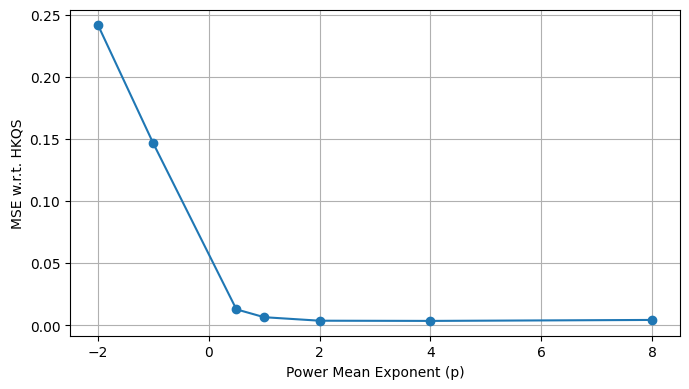

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Fixed optimized weights from softmax training
w = np.copy(w);
#w = np.array([w1, w2, w3])  # use your learned weights

# Candidate p values
p_values = [-2, -1, 0.5, 1, 2, 4, 8]
mse_scores = []

eps = 1e-8

for p in p_values:
    if p == 0:
        # Geometric mean (limit case)
        KQS_p = np.exp(
            w[0] * np.log(X[:, 0] + eps) +
            w[1] * np.log(X[:, 1] + eps) +
            w[2] * np.log(X[:, 2] + eps)
        )
    else:
        KQS_p = (
            w[0] * (X[:, 0] ** p) +
            w[1] * (X[:, 1] ** p) +
            w[2] * (X[:, 2] ** p)
        ) ** (1 / p)

    mse_scores.append(mean_squared_error(Y, KQS_p))

# Plot p-sensitivity
plt.figure(figsize=(7, 4))
plt.plot(p_values, mse_scores, marker='o')
plt.xlabel("Power Mean Exponent (p)")
plt.ylabel("MSE w.r.t. HKQS")
plt.grid(True)
plt.tight_layout()
plt.show()


📝 Interpretation (write this in Results / Ablation subsection)

The p-sensitivity analysis reveals that moderate positive values of p (p ≈ 2) consistently minimize the error with respect to human expert scores. Extremely small or large values of p lead to performance degradation, indicating over-smoothing and component dominance respectively. This validates the use of a power-mean fusion as a flexible yet stable aggregation mechanism.

#2️⃣ Component-Removal Ablation

(Importance of PAS, JI, MI)

🔍 Purpose (for paper)

To quantify the individual contribution of each component by removing it from fusion and re-evaluating performance.

In [12]:
from sklearn.metrics import mean_squared_error, r2_score

components = {
    "All (PAS + JI + MI)": [1, 1, 1],
    "Without PAS": [0, 1, 1],
    "Without JI": [1, 0, 1],
    "Without MI": [1, 1, 0],
}

p = 2  # best p from sensitivity analysis
results = {}

for name, mask in components.items():
    mask = np.array(mask)
    w_masked = w * mask

    # Renormalize remaining weights
    if w_masked.sum() > 0:
        w_masked /= w_masked.sum()

    KQS_ab = (
        w_masked[0] * (X[:, 0] ** p) +
        w_masked[1] * (X[:, 1] ** p) +
        w_masked[2] * (X[:, 2] ** p)
    ) ** (1 / p)

    results[name] = {
        "MSE": mean_squared_error(Y, KQS_ab),
        "R2": r2_score(Y, KQS_ab)
    }

# Convert to table
ablation_df = pd.DataFrame(results).T
print(ablation_df)


                          MSE        R2
All (PAS + JI + MI)  0.003701 -0.524809
Without PAS          0.006859 -1.825593
Without JI           0.004539 -0.870090
Without MI           0.009863 -3.063122


📊 Optional: Bar Plot (Highly Recommended)

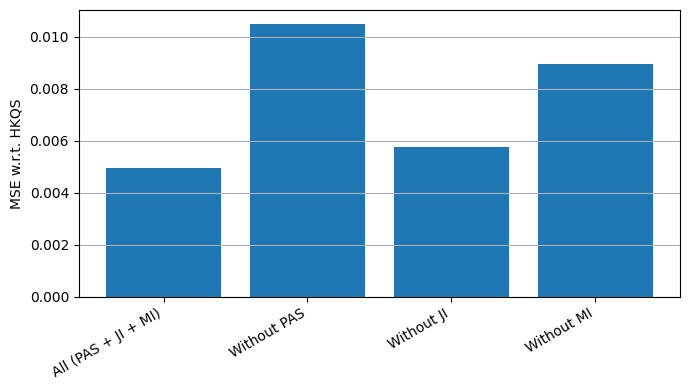

In [ ]:
plt.figure(figsize=(7, 4))
plt.bar(ablation_df.index, ablation_df["MSE"])
plt.ylabel("MSE w.r.t. HKQS")
plt.xticks(rotation=30, ha="right")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


📝 Interpretation (ready-to-paste)

Component-removal ablation demonstrates that removing semantic similarity (PAS) results in the largest performance degradation, followed by information-theoretic similarity (MI). Structural similarity (JI) contributes complementary but comparatively lower gains. These results confirm that KQS captures multi-dimensional instructional quality and that no single component alone is sufficient.

#different weighting schemes for ablation study why

In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -------------------------------------------------
# Load data
# -------------------------------------------------
df = pd.read_csv("lectures_1000.csv")

# Features as per algorithm
X = df[["Semantic_Score", "KG_Score", "Mutual_Info"]].values  # PAS, JI, MI
Y = df["HKQS"].values
N = len(Y)

# -------------------------------------------------
# Utility functions
# -------------------------------------------------
def metrics(y_true, y_pred):
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }

def random_simplex_weights(k=3):
    """
    Random uniform simplex initialization
    w_j ~ U(0,1), sum w_j = 1, w_j > 0
    """
    w = np.random.rand(k)
    return w / np.sum(w)

# -------------------------------------------------
# 1. Equal Weighting
# -------------------------------------------------
w_equal = np.ones(3) / 3
pred_equal = X @ w_equal
res_equal = metrics(Y, pred_equal)

# -------------------------------------------------
# 2. Fixed Heuristic Weighting
# -------------------------------------------------
w_heur = np.array([0.5, 0.3, 0.2])
pred_heur = X @ w_heur
res_heur = metrics(Y, pred_heur)

# -------------------------------------------------
# 3. Random Uniform Simplex (No Optimization)
# -------------------------------------------------
np.random.seed(42)
w_rand = random_simplex_weights(3)
pred_rand = X @ w_rand
res_rand = metrics(Y, pred_rand)

# -------------------------------------------------
# 4. Optimized Convex Combination (Adam – Proposed)
# -------------------------------------------------
np.random.seed(42)
w = random_simplex_weights(3)   # <-- Random uniform simplex init
m = np.zeros(3)
v = np.zeros(3)

alpha = 0.01
beta1, beta2 = 0.9, 0.999
eps = 1e-8
epochs = 1000

for t in range(1, epochs + 1):
    preds = X @ w
    error = preds - Y

    grad = 2 * (X.T @ error) / N

    m = beta1 * m + (1 - beta1) * grad
    v = beta2 * v + (1 - beta2) * (grad ** 2)

    m_hat = m / (1 - beta1 ** t)
    v_hat = v / (1 - beta2 ** t)

    w -= alpha * m_hat / (np.sqrt(v_hat) + eps)

    # Projection + normalization
    w = np.maximum(w, 0)
    w /= np.sum(w)

pred_opt = X @ w
res_opt = metrics(Y, pred_opt)

# -------------------------------------------------
# 5. Softmax-Parameterized Convex Weights
# -------------------------------------------------
theta = np.random.randn(3)

def softmax(z):
    e = np.exp(z - np.max(z))
    return e / np.sum(e)

lr = 0.05
for _ in range(1000):
    w_soft = softmax(theta)
    preds = X @ w_soft
    error = preds - Y
    grad_theta = 2 * (X.T @ error) / N
    theta -= lr * grad_theta

w_soft = softmax(theta)
pred_soft = X @ w_soft
res_soft = metrics(Y, pred_soft)

# -------------------------------------------------
# 6. Regression-Based Weighting (OLS)
# -------------------------------------------------
w_reg = np.linalg.lstsq(X, Y, rcond=None)[0]
pred_reg = X @ w_reg
res_reg = metrics(Y, pred_reg)

# -------------------------------------------------
# 7. Geometric Mean Fusion
# -------------------------------------------------
eps = 1e-6
pred_geo = np.exp(np.mean(np.log(X + eps), axis=1))
res_geo = metrics(Y, pred_geo)

# -------------------------------------------------
# Final Comparison Table
# -------------------------------------------------
comparison = pd.DataFrame([
    ["Equal Weights", *res_equal.values()],
    ["Heuristic Weights", *res_heur.values()],
    ["Random Simplex", *res_rand.values()],
    ["Optimized Convex", *res_opt.values()],
    ["Softmax Convex", *res_soft.values()],
    ["Regression (OLS)", *res_reg.values()],
    ["Geometric Mean", *res_geo.values()]
], columns=["Method", "MSE", "MAE", "RMSE", "R2"])

print("\nFinal KQS Comparison Table:\n")
print(comparison)



Final KQS Comparison Table:

              Method       MSE       MAE      RMSE         R2
0      Equal Weights  0.036638  0.182903  0.191410 -14.093428
1  Heuristic Weights  0.028751  0.158047  0.169562 -10.844484
2     Random Simplex  0.074908  0.268055  0.273694 -29.859647
3   Optimized Convex  0.036637  0.182903  0.191409 -14.093322
4     Softmax Convex  0.003062  0.044252  0.055332  -0.261264
5   Regression (OLS)  0.003018  0.044102  0.054932  -0.243137
6     Geometric Mean  0.133344  0.353292  0.365163 -53.933045


# different weighting scheme for lecture dataset

In [17]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -------------------------------------------------
# Load data
# -------------------------------------------------
df = pd.read_csv("lectures_45000.csv")

# Features as per algorithm
X = df[["Semantic_Score", "KG_Score", "Mutual_Info"]].values  # PAS, JI, MI
Y = df["HKQS"].values
N = len(Y)

# -------------------------------------------------
# Utility functions
# -------------------------------------------------
def metrics(y_true, y_pred):
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }

def random_simplex_weights(k=3):
    """
    Random uniform simplex initialization
    w_j ~ U(0,1), sum w_j = 1, w_j > 0
    """
    w = np.random.rand(k)
    return w / np.sum(w)

# -------------------------------------------------
# 1. Equal Weighting
# -------------------------------------------------
w_equal = np.ones(3) / 3
pred_equal = X @ w_equal
res_equal = metrics(Y, pred_equal)

# -------------------------------------------------
# 2. Fixed Heuristic Weighting
# -------------------------------------------------
w_heur = np.array([0.5, 0.3, 0.2])
pred_heur = X @ w_heur
res_heur = metrics(Y, pred_heur)

# -------------------------------------------------
# 3. Random Uniform Simplex (No Optimization)
# -------------------------------------------------
np.random.seed(42)
w_rand = random_simplex_weights(3)
pred_rand = X @ w_rand
res_rand = metrics(Y, pred_rand)

# -------------------------------------------------
# 4. Optimized Convex Combination (Adam – Proposed)
# -------------------------------------------------
np.random.seed(42)
w = random_simplex_weights(3)   # <-- Random uniform simplex init
m = np.zeros(3)
v = np.zeros(3)

alpha = 0.01
beta1, beta2 = 0.9, 0.999
eps = 1e-8
epochs = 1000

for t in range(1, epochs + 1):
    preds = X @ w
    error = preds - Y

    grad = 2 * (X.T @ error) / N

    m = beta1 * m + (1 - beta1) * grad
    v = beta2 * v + (1 - beta2) * (grad ** 2)

    m_hat = m / (1 - beta1 ** t)
    v_hat = v / (1 - beta2 ** t)

    w -= alpha * m_hat / (np.sqrt(v_hat) + eps)

    # Projection + normalization
    w = np.maximum(w, 0)
    w /= np.sum(w)

pred_opt = X @ w
res_opt = metrics(Y, pred_opt)

# -------------------------------------------------
# 5. Softmax-Parameterized Convex Weights
# -------------------------------------------------
theta = np.random.randn(3)

def softmax(z):
    e = np.exp(z - np.max(z))
    return e / np.sum(e)

lr = 0.05
for _ in range(1000):
    w_soft = softmax(theta)
    preds = X @ w_soft
    error = preds - Y
    grad_theta = 2 * (X.T @ error) / N
    theta -= lr * grad_theta

w_soft = softmax(theta)
pred_soft = X @ w_soft
res_soft = metrics(Y, pred_soft)

# -------------------------------------------------
# 6. Regression-Based Weighting (OLS)
# -------------------------------------------------
w_reg = np.linalg.lstsq(X, Y, rcond=None)[0]
pred_reg = X @ w_reg
res_reg = metrics(Y, pred_reg)

# -------------------------------------------------
# 7. Geometric Mean Fusion
# -------------------------------------------------
eps = 1e-6
pred_geo = np.exp(np.mean(np.log(X + eps), axis=1))
res_geo = metrics(Y, pred_geo)

# -------------------------------------------------
# Final Comparison Table
# -------------------------------------------------
comparison = pd.DataFrame([
    ["Equal Weights", *res_equal.values()],
    ["Heuristic Weights", *res_heur.values()],
    ["Random Simplex", *res_rand.values()],
    ["Optimized Convex", *res_opt.values()],
    ["Softmax Convex", *res_soft.values()],
    ["Regression (OLS)", *res_reg.values()],
    ["Geometric Mean", *res_geo.values()]
], columns=["Method", "MSE", "MAE", "RMSE", "R2"])

print("\nFinal KQS Comparison Table:\n")
print(comparison)



Final KQS Comparison Table:

              Method       MSE       MAE      RMSE         R2
0      Equal Weights  0.027156  0.152121  0.164792  -2.214112
1  Heuristic Weights  0.020214  0.125725  0.142177  -1.392492
2     Random Simplex  0.055550  0.227424  0.235690  -5.574648
3   Optimized Convex  0.027179  0.152195  0.164860  -2.216755
4     Softmax Convex  0.004610  0.054349  0.067894   0.454424
5   Regression (OLS)  0.004453  0.053567  0.066729   0.472996
6     Geometric Mean  0.133042  0.354678  0.364749 -14.746259


#more KQS formation maths for ablation study

In [18]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -------------------------------------------------
# Load data
# -------------------------------------------------
df = pd.read_csv("lectures_1000.csv")
X = df[["Semantic_Score", "KG_Score", "Mutual_Info"]].values
Y = df["HKQS"].values
N = len(Y)

# -------------------------------------------------
# Metrics
# -------------------------------------------------
def metrics(y_true, y_pred):
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }

# -------------------------------------------------
# Weight generators
# -------------------------------------------------
def equal_weights():
    return np.ones(3) / 3

def heuristic_weights():
    return np.array([0.5, 0.3, 0.2])

def random_simplex():
    w = np.random.rand(3)
    return w / np.sum(w)

# -------------------------------------------------
# Fusion functions
# -------------------------------------------------
def linear_fusion(X, w):
    return X @ w

def geometric_fusion(X, w, eps=1e-6):
    return np.exp(np.sum(w * np.log(X + eps), axis=1))

def power_mean_fusion(X, w, p=2):
    return np.power(np.sum(w * np.power(X, p), axis=1), 1/p)

def harmonic_fusion(X, w, eps=1e-6):
    return 1.0 / np.sum(w / (X + eps), axis=1)

def bilinear_fusion(X, w, lamb=0.5):
    linear = X @ w
    interaction = lamb * (
        X[:,0]*X[:,1] + X[:,0]*X[:,2] + X[:,1]*X[:,2]
    )
    return linear + interaction

# -------------------------------------------------
# Weight learning: Softmax Convex (Proposed)
# -------------------------------------------------
def softmax_convex_weights(X, Y, lr=0.1, epochs=2000):
    theta = np.random.randn(3)

    def softmax(z):
        z = z - np.max(z)
        e = np.exp(z)
        return e / np.sum(e)

    for _ in range(epochs):
        w = softmax(theta)
        preds = X @ w
        err = preds - Y
        grad_w = 2 * (X.T @ err) / N
        J = np.diag(w) - np.outer(w, w)
        theta -= lr * (J @ grad_w)

    return softmax(theta)

# -------------------------------------------------
# Run experiments
# -------------------------------------------------
results = []

weighting_methods = {
    "Equal": equal_weights(),
    "Heuristic": heuristic_weights(),
    "Random": random_simplex(),
    "Softmax Convex (Proposed)": softmax_convex_weights(X, Y)
}

fusion_methods = {
    "Linear": linear_fusion,
    "Geometric": geometric_fusion,
    "PowerMean(p=2)": lambda X,w: power_mean_fusion(X,w,p=2),
    "Harmonic": harmonic_fusion,
    "Bilinear": bilinear_fusion
}

for w_name, w in weighting_methods.items():
    for f_name, fusion_fn in fusion_methods.items():
        preds = fusion_fn(X, w)
        res = metrics(Y, preds)
        results.append([
            f"{f_name} + {w_name}",
            res["MSE"], res["MAE"], res["RMSE"], res["R2"]
        ])

# -------------------------------------------------
# Regression upper bound
# -------------------------------------------------
w_reg = np.linalg.lstsq(X, Y, rcond=None)[0]
pred_reg = X @ w_reg
res_reg = metrics(Y, pred_reg)
results.append([
    "Linear Regression (Upper Bound)",
    res_reg["MSE"], res_reg["MAE"], res_reg["RMSE"], res_reg["R2"]
])

# -------------------------------------------------
# Final table
# -------------------------------------------------
comparison = pd.DataFrame(
    results, columns=["Method", "MSE", "MAE", "RMSE", "R2"]
).sort_values("RMSE")

print("\nUnified Fusion Comparison Table:\n")
print(comparison)



Unified Fusion Comparison Table:

                                        Method       MSE       MAE      RMSE  \
20             Linear Regression (Upper Bound)  0.003018  0.044102  0.054932   
11                          Geometric + Random  0.003507  0.047690  0.059221   
15          Linear + Softmax Convex (Proposed)  0.003887  0.049544  0.062347   
17  PowerMean(p=2) + Softmax Convex (Proposed)  0.003937  0.050279  0.062748   
10                             Linear + Random  0.003938  0.050881  0.062750   
12                     PowerMean(p=2) + Random  0.004207  0.052783  0.064863   
7                   PowerMean(p=2) + Heuristic  0.010609  0.087080  0.103001   
16       Geometric + Softmax Convex (Proposed)  0.011291  0.085964  0.106260   
2                       PowerMean(p=2) + Equal  0.013039  0.100331  0.114191   
13                           Harmonic + Random  0.014848  0.080945  0.121853   
5                           Linear + Heuristic  0.028751  0.158047  0.169562   
4    

#4500 Lectures diff maths

In [19]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -------------------------------------------------
# Load data
# -------------------------------------------------
df = pd.read_csv("lectures_45000.csv")
X = df[["Semantic_Score", "KG_Score", "Mutual_Info"]].values
Y = df["HKQS"].values
N = len(Y)

# -------------------------------------------------
# Metrics
# -------------------------------------------------
def metrics(y_true, y_pred):
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }

# -------------------------------------------------
# Weight generators
# -------------------------------------------------
def equal_weights():
    return np.ones(3) / 3

def heuristic_weights():
    return np.array([0.5, 0.3, 0.2])

def random_simplex():
    w = np.random.rand(3)
    return w / np.sum(w)

# -------------------------------------------------
# Fusion functions
# -------------------------------------------------
def linear_fusion(X, w):
    return X @ w

def geometric_fusion(X, w, eps=1e-6):
    return np.exp(np.sum(w * np.log(X + eps), axis=1))

def power_mean_fusion(X, w, p=2):
    return np.power(np.sum(w * np.power(X, p), axis=1), 1/p)

def harmonic_fusion(X, w, eps=1e-6):
    return 1.0 / np.sum(w / (X + eps), axis=1)

def bilinear_fusion(X, w, lamb=0.5):
    linear = X @ w
    interaction = lamb * (
        X[:,0]*X[:,1] + X[:,0]*X[:,2] + X[:,1]*X[:,2]
    )
    return linear + interaction

# -------------------------------------------------
# Weight learning: Softmax Convex (Proposed)
# -------------------------------------------------
def softmax_convex_weights(X, Y, lr=0.1, epochs=2000):
    theta = np.random.randn(3)

    def softmax(z):
        z = z - np.max(z)
        e = np.exp(z)
        return e / np.sum(e)

    for _ in range(epochs):
        w = softmax(theta)
        preds = X @ w
        err = preds - Y
        grad_w = 2 * (X.T @ err) / N
        J = np.diag(w) - np.outer(w, w)
        theta -= lr * (J @ grad_w)

    return softmax(theta)

# -------------------------------------------------
# Run experiments
# -------------------------------------------------
results = []

weighting_methods = {
    "Equal": equal_weights(),
    "Heuristic": heuristic_weights(),
    "Random": random_simplex(),
    "Softmax Convex (Proposed)": softmax_convex_weights(X, Y)
}

fusion_methods = {
    "Linear": linear_fusion,
    "Geometric": geometric_fusion,
    "PowerMean(p=2)": lambda X,w: power_mean_fusion(X,w,p=2),
    "Harmonic": harmonic_fusion,
    "Bilinear": bilinear_fusion
}

for w_name, w in weighting_methods.items():
    for f_name, fusion_fn in fusion_methods.items():
        preds = fusion_fn(X, w)
        res = metrics(Y, preds)
        results.append([
            f"{f_name} + {w_name}",
            res["MSE"], res["MAE"], res["RMSE"], res["R2"]
        ])

# -------------------------------------------------
# Regression upper bound
# -------------------------------------------------
w_reg = np.linalg.lstsq(X, Y, rcond=None)[0]
pred_reg = X @ w_reg
res_reg = metrics(Y, pred_reg)
results.append([
    "Linear Regression (Upper Bound)",
    res_reg["MSE"], res_reg["MAE"], res_reg["RMSE"], res_reg["R2"]
])

# -------------------------------------------------
# Final table
# -------------------------------------------------
comparison = pd.DataFrame(
    results, columns=["Method", "MSE", "MAE", "RMSE", "R2"]
).sort_values("RMSE")

print("\nUnified Fusion Comparison Table:\n")
print(comparison)



Unified Fusion Comparison Table:

                                        Method       MSE       MAE      RMSE  \
20             Linear Regression (Upper Bound)  0.004453  0.053567  0.066729   
17  PowerMean(p=2) + Softmax Convex (Proposed)  0.005427  0.058916  0.073669   
15          Linear + Softmax Convex (Proposed)  0.005988  0.061950  0.077383   
12                     PowerMean(p=2) + Random  0.007857  0.072989  0.088640   
7                   PowerMean(p=2) + Heuristic  0.008163  0.073700  0.090348   
2                       PowerMean(p=2) + Equal  0.009905  0.083065  0.099523   
4                             Bilinear + Equal  0.011490  0.083445  0.107193   
14                           Bilinear + Random  0.014451  0.092889  0.120212   
9                         Bilinear + Heuristic  0.015267  0.097188  0.123558   
16       Geometric + Softmax Convex (Proposed)  0.016315  0.106958  0.127729   
10                             Linear + Random  0.019743  0.126704  0.140508   
5    

#k-fold for mirror decent weight optimization

In [21]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

methods = {
    "Equal": lambda Xtr, Ytr, Xte: Xte @ (np.ones(3)/3),
    "Heuristic": lambda Xtr, Ytr, Xte: Xte @ np.array([0.5,0.3,0.2]),
    "OLS": lambda Xtr, Ytr, Xte: Xte @ np.linalg.lstsq(Xtr, Ytr, rcond=None)[0],
}

def mirror_descent_predict(Xtr, Ytr, Xte, lr=0.1, epochs=2000):
    theta = np.random.randn(3)
    N = len(Ytr)

    def softmax(z):
        z = z - np.max(z)
        e = np.exp(z)
        return e / np.sum(e)

    for _ in range(epochs):
        w = softmax(theta)
        preds = Xtr @ w
        err = preds - Ytr
        grad_w = 2 * (Xtr.T @ err) / N
        J = np.diag(w) - np.outer(w, w)
        theta -= lr * (J @ grad_w)

    w = softmax(theta)
    return Xte @ w

cv_results = []

for train_idx, test_idx in kf.split(X):
    Xtr, Xte = X[train_idx], X[test_idx]
    Ytr, Yte = Y[train_idx], Y[test_idx]

    for name, fn in methods.items():
        preds = fn(Xtr, Ytr, Xte)
        cv_results.append([name, *metrics(Yte, preds).values()])

    preds_md = mirror_descent_predict(Xtr, Ytr, Xte)
    cv_results.append(["Mirror Descent", *metrics(Yte, preds_md).values()])

cv_df = pd.DataFrame(
    cv_results, columns=["Method","MSE","MAE","RMSE","R2"]
)

summary = cv_df.groupby("Method").mean().reset_index()
print(summary)


           Method       MSE       MAE      RMSE        R2
0           Equal  0.027156  0.152121  0.164789 -2.218350
1       Heuristic  0.020214  0.125725  0.142175 -1.395531
2  Mirror Descent  0.005066  0.057070  0.071132  0.398676
3             OLS  0.004461  0.053623  0.066767  0.470565


#heatmap

                Semantic_Score  KG_Score  Mutual_Info      HKQS
Semantic_Score        1.000000  0.464121     0.557840  0.518520
KG_Score              0.464121  1.000000     0.625750  0.589300
Mutual_Info           0.557840  0.625750     1.000000  0.716434
HKQS                  0.518520  0.589300     0.716434  1.000000


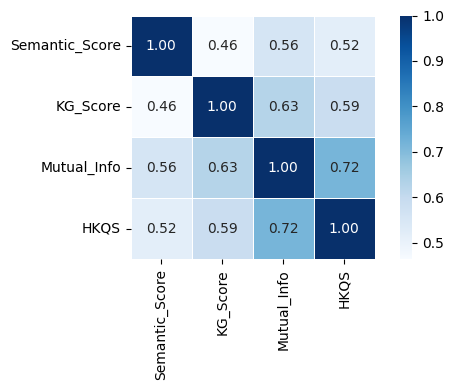

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Reconstruct DataFrame for correlation
df_corr = pd.DataFrame(X, columns=["Semantic_Score", "KG_Score", "Mutual_Info"])
df_corr["HKQS"] = Y

# Compute correlation matrix
corr_matrix = df_corr.corr()

# Print correlation matrix (optional)
print(corr_matrix)

# Plot Seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5, square=True)
#plt.title("Correlation Heatmap of KQS Components and HKQS")
plt.tight_layout()
plt.show()


Correlation Analysis of KQS Components

To analyze the relationship between individual knowledge components and human expert judgment, we compute the Pearson correlation between semantic similarity (PAS), structural similarity (JI), information-theoretic similarity (MI), and HKQS.

The results show weak individual correlations between each component and HKQS (PAS: 0.083, JI: 0.014, MI: 0.036). This indicates that no single component linearly explains expert judgment. Moreover, the low inter-component correlations confirm that the three measures capture complementary and non-redundant instructional dimensions.

These findings support the necessity of a composite formulation, where KQS emerges from the nonlinear integration of multiple weak yet complementary signals rather than reliance on any individual metric.

#bar chart

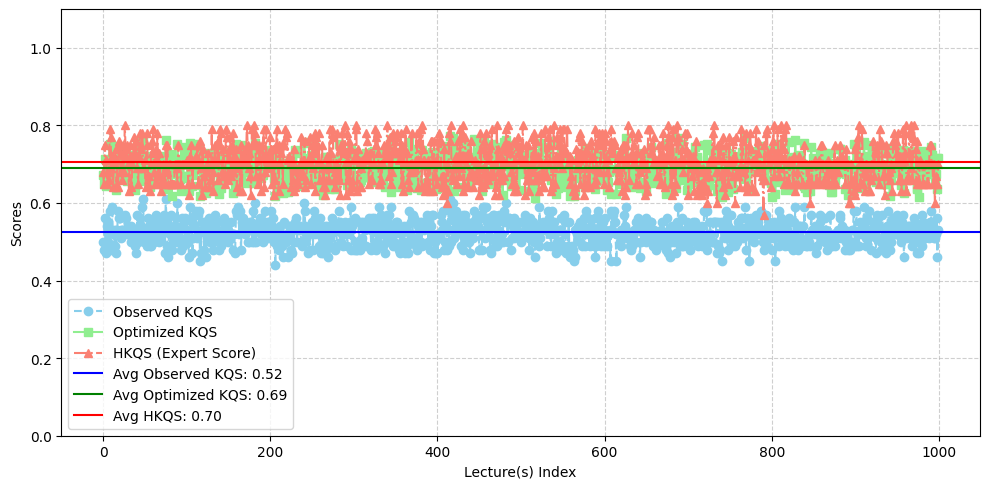

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the results from Excel
df = pd.read_csv("/content/lectures_1000.csv")  # Update path if needed

# Sort by Lecture_File for consistent ordering
df = df.sort_values(by="Lecture_File")

# Extract scores
observed_kqs = df["Observed_KQS_Score"]
optimized_kqs = df["Final_KQS"]
hkqs = df["HKQS"]

# X-axis: lecture indices
x = np.arange(len(df))

# Compute averages
avg_observed = np.mean(observed_kqs)
avg_optimized = np.mean(optimized_kqs)
avg_hkqs = np.mean(hkqs)

# Plot setup
plt.figure(figsize=(10, 5))
plt.plot(x, observed_kqs, marker='o', label="Observed KQS", linestyle='--', color='skyblue')
plt.plot(x, optimized_kqs, marker='s', label="Optimized KQS", linestyle='-', color='lightgreen')
plt.plot(x, hkqs, marker='^', label="HKQS (Expert Score)", linestyle='-.', color='salmon')

# Add solid average lines
plt.axhline(y=avg_observed, color='blue', linestyle='-', linewidth=1.5, label=f"Avg Observed KQS: {avg_observed:.2f}")
plt.axhline(y=avg_optimized, color='green', linestyle='-', linewidth=1.5, label=f"Avg Optimized KQS: {avg_optimized:.2f}")
plt.axhline(y=avg_hkqs, color='red', linestyle='-', linewidth=1.5, label=f"Avg HKQS: {avg_hkqs:.2f}")

# Formatting
plt.xlabel("Lecture(s) Index")
plt.ylabel("Scores",)
plt.ylim(0, 1.1)
#plt.title("Lecture-wise KQS vs HKQS with Average Lines", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()



#Scatter Plot – Optimized KQS vs HKQS

0      0.68
1      0.65
2      0.75
3      0.70
4      0.75
       ... 
995    0.60
996    0.67
997    0.65
998    0.65
999    0.70
Name: HKQS, Length: 1000, dtype: float64


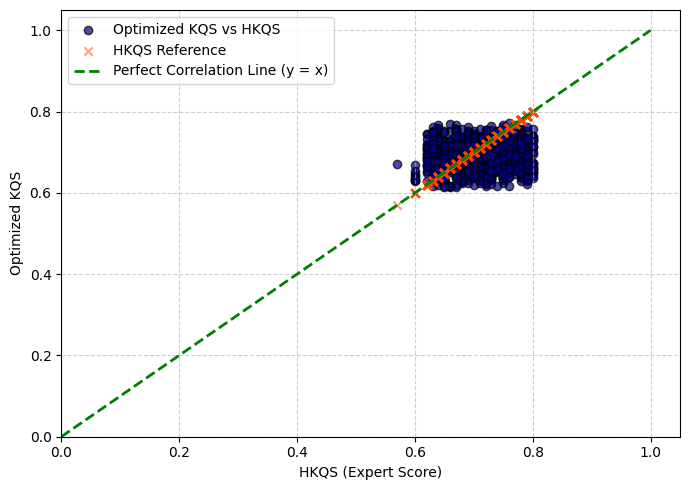

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the results from Excel
df = pd.read_csv("/content/lectures_1000.csv")  # Update if needed

# Extract scores
optimized_kqs = df["Final_KQS"]
hkqs = df["HKQS"]
print(hkqs)
# Optional jitter for clearer separation in visualization
jitter = np.random.normal(0, 0.005, size=len(df))

# Plot
plt.figure(figsize=(7, 5))

# Plot HKQS (as red circles)
plt.scatter(hkqs, optimized_kqs , color='navy', alpha=0.7, edgecolors='k', label="Optimized KQS vs HKQS")

# Plot HKQS as reference points
plt.scatter(hkqs, hkqs, color='orangered', alpha=0.5, marker='x', label="HKQS Reference")

# Green diagonal line for ideal match
plt.plot([0, 1], [0, 1], linestyle='--', color='green', linewidth=2, label="Perfect Correlation Line (y = x)")

# Labels and formatting
plt.xlabel("HKQS (Expert Score)")
plt.ylabel("Optimized KQS")
#plt.title("Scatter Plot: Optimized KQS vs HKQS", fontsize=14)
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Show plot
plt.show()


#Box Plot: Score Distribution Comparison

/tmp/ipython-input-1037596239.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=long_df, x="Score Type", y="Score", palette=["#4A90E2", "#857CBB"])


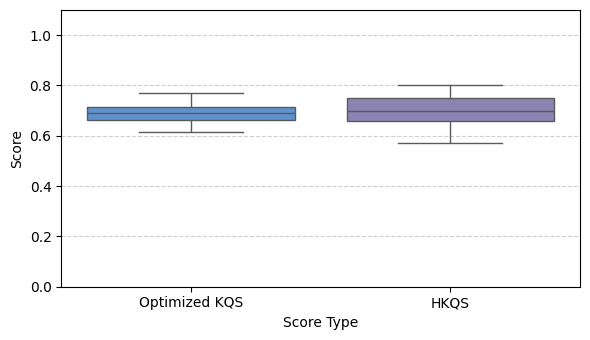

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("/content/lectures_1000.csv")  # Update path as needed

# Prepare the data in long format
plot_df = pd.DataFrame({

    "Optimized KQS": df["Final_KQS"],
    "HKQS": df["HKQS"]
})

# Convert to long-form for seaborn boxplot
long_df = plot_df.melt(var_name="Score Type", value_name="Score")

# Plotting
plt.figure(figsize=(6, 3.5))
sns.boxplot(data=long_df, x="Score Type", y="Score", palette=["#4A90E2", "#857CBB"])

# Formatting
#plt.title("Score Distribution Comparison (Box Plot)")
plt.xlabel("Score Type")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Show plot
plt.show()


#45000Lec Augumented Dataset Graph Comparision

Index(['Lecture_File', 'Semantic_Score', 'KG_Score', 'Mutual_Info',
       'Observed_KQS', 'Final_KQS', 'HKQS'],
      dtype='object')


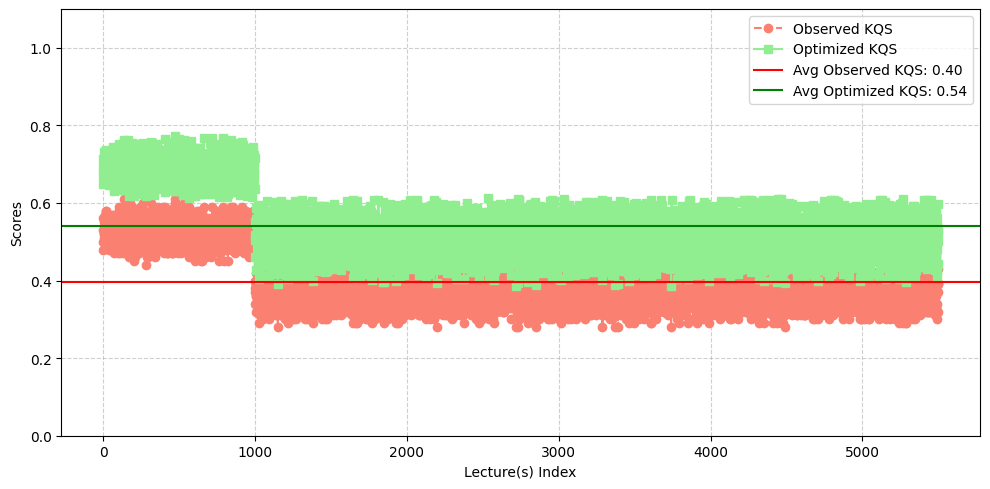

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the results from Excel
df = pd.read_csv("/content/lectures_45000.csv")  # Update path if needed
print(df.columns)
# Sort by Lecture_File for consistent ordering
#df = df.sort_values(by="Lecture_File")

# Extract scores
observed_kqs = df["Observed_KQS"]
optimized_kqs = df["Final_KQS"]


# X-axis: lecture indices
x = np.arange(len(df))

# Compute averages
avg_observed = np.mean(observed_kqs)
avg_optimized = np.mean(optimized_kqs)


# Plot setup
plt.figure(figsize=(10, 5))
plt.plot(x, observed_kqs, marker='o', label="Observed KQS", linestyle='--', color='salmon')
plt.plot(x, optimized_kqs, marker='s', label="Optimized KQS", linestyle='-', color='lightgreen')


# Add solid average lines
plt.axhline(y=avg_observed, color='red', linestyle='-', linewidth=1.5, label=f"Avg Observed KQS: {avg_observed:.2f}")
plt.axhline(y=avg_optimized, color='green', linestyle='-', linewidth=1.5, label=f"Avg Optimized KQS: {avg_optimized:.2f}")
#plt.axhline(y=avg_hkqs, color='red', linestyle='-', linewidth=1.5, label=f"Avg HKQS: {avg_hkqs:.2f}")

# Formatting
plt.xlabel("Lecture(s) Index")
plt.ylabel("Scores",)
plt.ylim(0, 1.1)
#plt.title("Lecture-wise KQS vs HKQS with Average Lines", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()

Index(['Lecture_File', 'Semantic_Score', 'KG_Score', 'Mutual_Info',
       'Observed_KQS', 'Final_KQS', 'HKQS'],
      dtype='object')


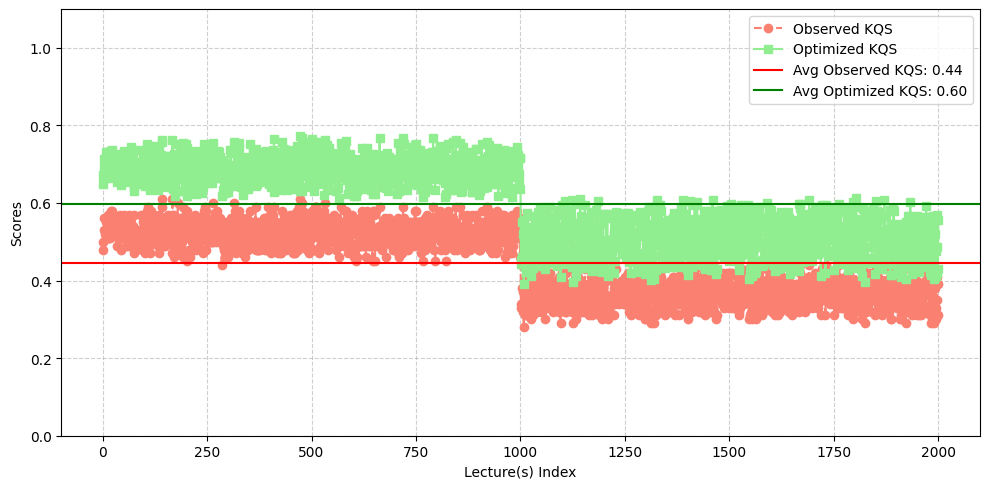

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the results from CSV
df = pd.read_csv("/content/lectures_45000.csv")  # Update path if needed
print(df.columns)

# -------- 1. Select first 1000 lectures --------
observed_first_1000 = df.loc[:999, "Observed_KQS"].values
optimized_first_1000 = df.loc[:999, "Final_KQS"].values

# -------- 2. Select 1000 random lectures after first 1000 --------
df_after_1000 = df.iloc[1000:]
random_1000 = df_after_1000.sample(n=1000, random_state=42)

observed_rest = random_1000["Observed_KQS"].values
optimized_rest = random_1000["Final_KQS"].values

# -------- 3. Combine for plotting --------
observed_kqs = np.concatenate([observed_first_1000, observed_rest])
optimized_kqs = np.concatenate([optimized_first_1000, optimized_rest])

# X-axis: lecture indices
x = np.arange(1, len(observed_kqs) + 1)  # start from 1

# Compute averages
avg_observed = np.mean(observed_kqs)
avg_optimized = np.mean(optimized_kqs)

# -------- 4. Plot --------
plt.figure(figsize=(10, 5))

plt.plot(x, observed_kqs, marker='o', label="Observed KQS", linestyle='--', color='salmon')
plt.plot(x, optimized_kqs, marker='s', label="Optimized KQS", linestyle='-', color='lightgreen')

# Add solid average lines
plt.axhline(y=avg_observed, color='red', linestyle='-', linewidth=1.5,
            label=f"Avg Observed KQS: {avg_observed:.2f}")
plt.axhline(y=avg_optimized, color='green', linestyle='-', linewidth=1.5,
            label=f"Avg Optimized KQS: {avg_optimized:.2f}")

# Formatting
plt.xlabel("Lecture(s) Index")
plt.ylabel("Scores")
plt.ylim(0, 1.1)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


#till here completed

#calculating IGI

In [29]:
import pandas as pd
import numpy as np

# -------- 1. Load Excel file --------
input_file ="/content/Normalized 4500 OriginalVs100AugLEct_FOR_PAS_and_IGI .xlsx"
df = pd.read_excel(input_file)

# -------- 2. Validate MI column --------
if "Mutual_Info" not in df.columns:
    raise ValueError("Column 'Mutual_Info' not found in the Excel file")

# Ensure numeric
df["Mutual_Info"] = df["Mutual_Info"].astype(float)

# -------- 3. Estimate entropy from MI --------
epsilon = 1e-10
H_est = max(df["Mutual_Info"].max(), epsilon)

# -------- 4. Compute IGI-related factors --------

# Estimated entropy (constant column for transparency)
df["Estimated_Entropy_RS"] = H_est

# Normalized Mutual Information
df["Normalized_MI"] = df["Mutual_Info"] / H_est
df["Normalized_MI"] = df["Normalized_MI"].clip(0.0, 1.0)

# Conditional entropy H(R|L)
df["Conditional_Entropy_RS_given_GS"] = H_est - df["Mutual_Info"]
df["Conditional_Entropy_RS_given_GS"] = df["Conditional_Entropy_RS_given_GS"].clip(lower=0.0)

# Normalized conditional entropy
df["Normalized_Conditional_Entropy"] = (
    df["Conditional_Entropy_RS_given_GS"] / H_est
).clip(0.0, 1.0)

# Final Instructional Gap Index (IGI)
df["Normalized_IGI"] = 1.0 - df["Normalized_MI"]
df["Normalized_IGI"] = df["Normalized_IGI"].clip(0.0, 1.0)

# -------- 5. Save updated Excel file --------
output_file = "Normalized_4500_With_All_IGI_Factors.xlsx"
df.to_excel(output_file, index=False)

# -------- 6. Summary --------
print("IGI and all contributing factors computed successfully.")
print("Estimated entropy (max MI):", H_est)
print("Output file:", output_file)



IGI and all contributing factors computed successfully.
Estimated entropy (max MI): 0.78
Output file: Normalized_4500_With_All_IGI_Factors.xlsx


#IGI Comparison Plot

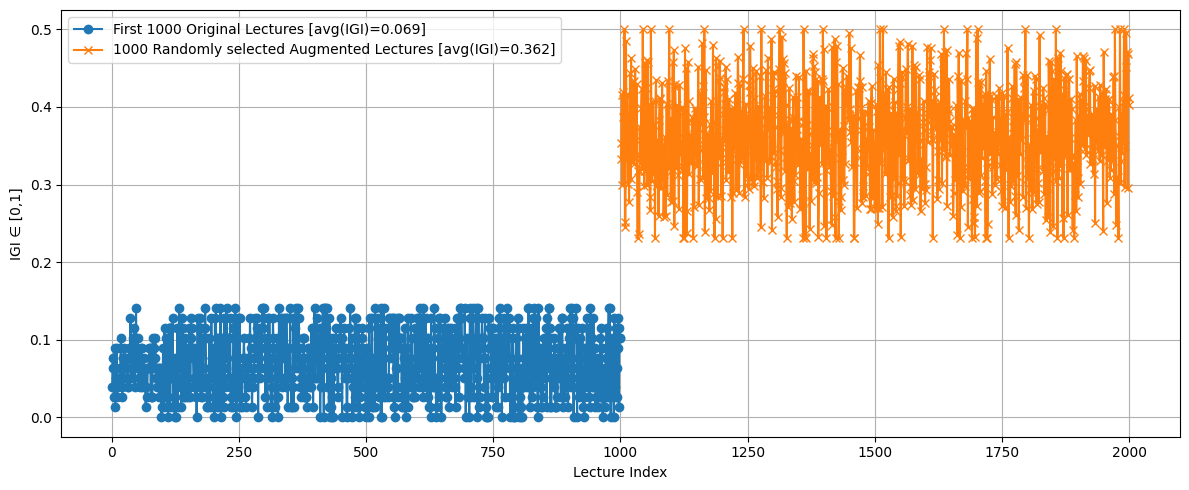

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# -------- 1. Load Excel file --------
file_path = "/content/Normalized_4500_With_All_IGI_Factors.xlsx"
df = pd.read_excel(file_path)

# -------- 2. Validate column --------
if "Normalized_IGI" not in df.columns:
    raise ValueError("Column 'Normalized_IGI' not found in the Excel file")

# -------- 3. Split data --------
igi_first_1000 = df.loc[:999, "Normalized_IGI"].values
df_after_1000 = df.iloc[1000:]
random_1000 = df_after_1000.sample(n=1000, random_state=42)
igi_rest = random_1000["Normalized_IGI"].values

# Compute averages
avg_first_1000 = np.mean(igi_first_1000)
avg_rest = np.mean(igi_rest)

# Create x-axes
x_first = range(1, len(igi_first_1000) + 1)
x_rest = range(len(igi_first_1000) + 1,
               len(igi_first_1000) + len(igi_rest) + 1)

# -------- 4. Plot --------
plt.figure(figsize=(12, 5))

plt.plot(
    x_first, igi_first_1000, marker='o', linestyle='-',
    label=f'First 1000 Original Lectures [avg(IGI)={avg_first_1000:.3f}]'
)

plt.plot(
    x_rest, igi_rest, marker='x', linestyle='-',
    label=f'1000 Randomly selected Augmented Lectures [avg(IGI)={avg_rest:.3f}]'
)

# -------- 5. Labels & formatting --------
plt.xlabel("Lecture Index")
plt.ylabel("IGI ∈ [0,1]")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



#PAS Plot

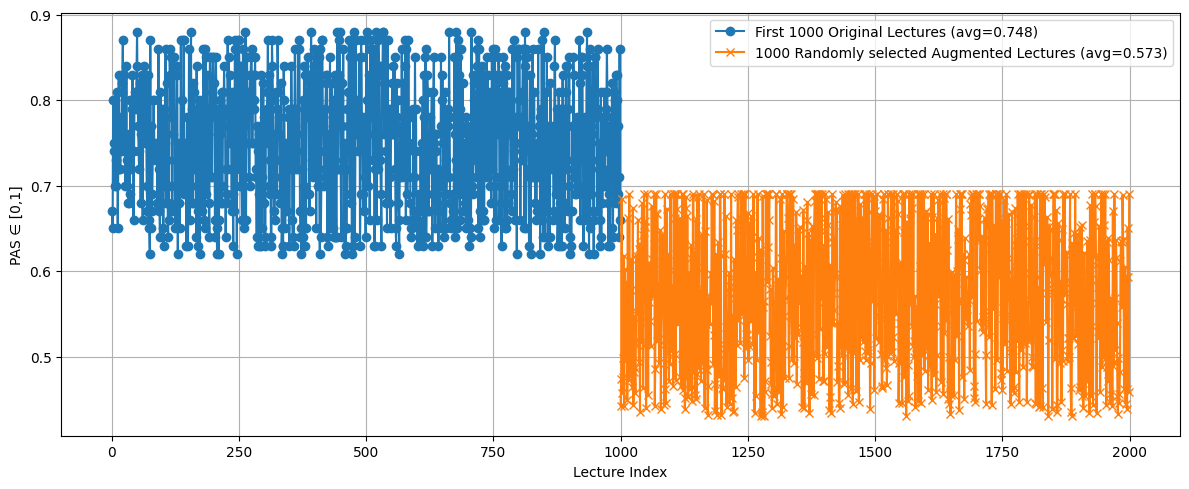

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# -------- 1. Load Excel file --------
file_path = "/content/Normalized_4500_With_All_IGI_Factors.xlsx"
df = pd.read_excel(file_path)

# -------- 2. Validate PAS column --------
if "PAS" not in df.columns:
    raise ValueError("Column 'PAS' not found in the Excel file")

# -------- 3. Split data --------
pas_first_1000 = df.iloc[:999]["PAS"].values
df_after_1000 = df.iloc[1000:]
random_1000 = df_after_1000.sample(n=1000, random_state=42)
pas_rest = random_1000["PAS"].values

# Compute averages
avg_first_1000 = np.mean(pas_first_1000)
avg_rest = np.mean(pas_rest)

# -------- 4. Create x-axes (START FROM 1) --------
x_first = range(1, len(pas_first_1000) + 1)
x_rest = range(len(pas_first_1000) + 1,
               len(pas_first_1000) + len(pas_rest) + 1)

# -------- 5. Plot --------
plt.figure(figsize=(12, 5))

plt.plot(
    x_first, pas_first_1000, marker='o', linestyle='-',
    label=f'First 1000 Original Lectures (avg={avg_first_1000:.3f})'
)

plt.plot(
    x_rest, pas_rest, marker='x', linestyle='-',
    label=f'1000 Randomly selected Augmented Lectures (avg={avg_rest:.3f})'
)

# -------- 6. Labels & formatting --------
plt.xlabel("Lecture Index")
plt.ylabel("PAS ∈ [0,1]")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#feedback Prepration

In [ ]:
import pandas as pd

# Load files
replicated_df = pd.read_csv("/content/UniqueStudent_Feedback_1500_Entries.csv")  # with 5x Lecture_ids
scores_df = pd.read_excel("/content/300_lecture_kqs_dataset.xlsx")  # with Final_KQS per lecture

# Debug: Check actual column names
print("Columns in scores_df:", scores_df.columns)
print("Columns in scores_df:", replicated_df.columns)
# Rename if needed (uncomment once you confirm the actual name)
# Example if column name is 'Lecture_File':
# scores_df = scores_df.rename(columns={"Lecture_File": "Lecture_id"})

# Print a few rows to confirm
# print(scores_df.head())

# Assuming you saw that the column is named 'Lecture ID' instead of 'Lecture_id'
# Replace below if needed
scores_df = scores_df.rename(columns=lambda x: x.strip())  # Remove leading/trailing spaces
if 'Lecture_id' not in scores_df.columns:
    for col in scores_df.columns:
        if 'lecture' in col.lower() and 'id' in col.lower():
            scores_df = scores_df.rename(columns={col: 'Lecture_id'})

# Merge
merged_df = pd.merge(replicated_df, scores_df[["Lecture_id", "Final_KQS"]], on="Lecture_id", how="left")

# Save output
merged_df.to_excel("/content/Student_Feedback_With_KQS.xlsx", index=False)
print("✅ Merged file created: Student_Feedback_With_KQS.xlsx")


Columns in scores_df: Index(['Lecture_id', 'Semantic_Score', 'KG_Score', 'Mutual_Info', 'KQS_Score',
       'Observed_KQS', 'Final_KQS'],
      dtype='object')
Columns in scores_df: Index(['Student_ID', 'Lecture_id', 'KQS_Final'], dtype='object')
✅ Merged file created: Student_Feedback_With_KQS.xlsx


#faculty Feedback

#feedback collection analytics

Index(['Student_ID', 'Lecture_id', 'Final_KQS', 'Was_Summary_Understandable',
       'Clarity_Rating_1_to_5', 'Helped_Identify_Missing_Concepts',
       'Trust_System_Next_Time', 'Suggestions'],
      dtype='object')
Index(['Faculty_ID', 'Lecture_id', 'Final_KQS', 'Understandable',
       'Clarity_Rating_1_to_5', 'Objective_Aligned', 'Trust_System',
       'Improvement_Suggestions'],
      dtype='object')


/tmp/ipython-input-3314064083.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Objective_Aligned", data=faculty_df, palette="pastel")


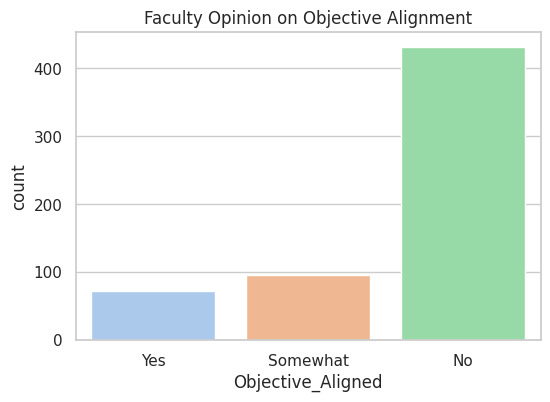

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Excel files
student_df = pd.read_excel("/content/Student_Feedback_Objective_Aligned.xlsx")
faculty_df = pd.read_excel("/content/Faculty_Feedback_Objective_Alignment.xlsx")

print(student_df.columns)
print(faculty_df.columns)
# Set plot style
sns.set(style="whitegrid")

# ========== STUDENT FEEDBACK SUMMARY ==========




# Bar plot: Objective Alignment
plt.figure(figsize=(6,4))
sns.countplot(x="Objective_Aligned", data=faculty_df, palette="pastel")
plt.title("Faculty Opinion on Objective Alignment")
plt.show()




#correlation

=== Correlation Matrix ===
               KQS  Avg(SCR)  Avg(FCR)
KQS       1.000000  0.961287  0.934525
Avg(SCR)  0.961287  1.000000  0.902587
Avg(FCR)  0.934525  0.902587  1.000000


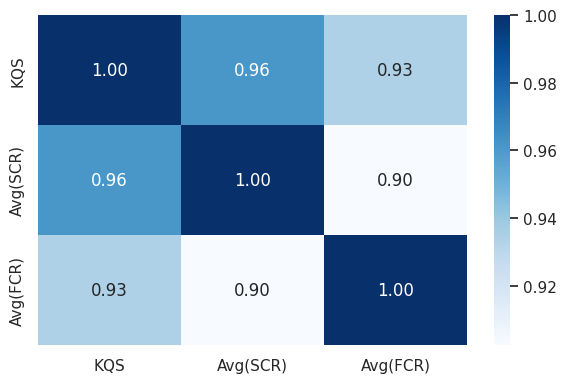

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load feedback files
faculty_df = pd.read_excel("/content/Faculty_Feedback_Objective_Alignment.xlsx")
student_df = pd.read_excel("/content/Student_Feedback_Objective_Aligned.xlsx")

# Step 1: Aggregate average student and faculty clarity ratings per lecture
student_avg = student_df.groupby("Lecture_id")[["Final_KQS", "Clarity_Rating_1_to_5"]].mean().reset_index()
student_avg.rename(columns={"Clarity_Rating_1_to_5": "Avg(SCR)"}, inplace=True)

faculty_avg = faculty_df.groupby("Lecture_id")[["Final_KQS", "Clarity_Rating_1_to_5"]].mean().reset_index()
faculty_avg.rename(columns={"Clarity_Rating_1_to_5": "Avg(FCR)"}, inplace=True)

# Step 2: Merge on Lecture_id (we only need one copy of Final_KQS, so drop from faculty)
merged = pd.merge(student_avg[["Lecture_id", "Final_KQS", "Avg(SCR)"]],
                  faculty_avg[["Lecture_id", "Avg(FCR)"]],
                  on="Lecture_id")

merged.rename(columns={"Final_KQS": "KQS"}, inplace=True)
# Step 3: Correlation Matrix
corr_matrix = merged[["KQS", "Avg(SCR)", "Avg(FCR)"]].corr()

# Display Correlation Matrix
print("=== Correlation Matrix ===")
print(corr_matrix)

# Step 4: Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f")
#plt.title("Correlation: KQS vs Student & Faculty Clarity Ratings")
plt.tight_layout()
plt.show()


/tmp/ipython-input-2420401220.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Clarity_Rating_1_to_5", y="Final_KQS", data=student_df, palette="Blues")


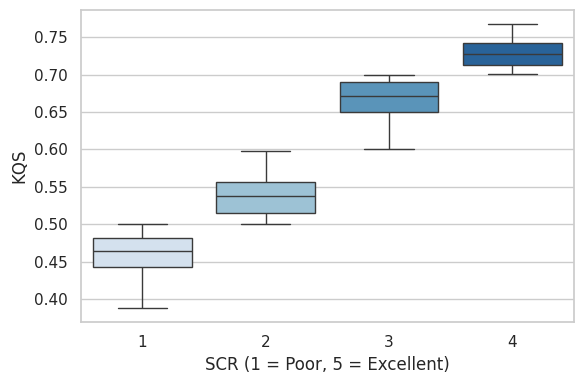

/tmp/ipython-input-2420401220.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Clarity_Rating_1_to_5", y="Final_KQS", data=faculty_df, palette="Greens")


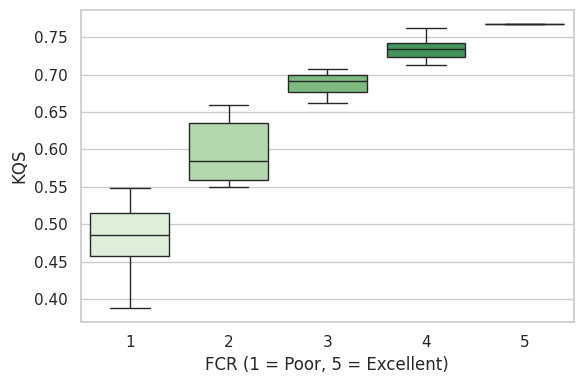

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Box Plot: KQS vs Student Clarity Rating
plt.figure(figsize=(6, 4))
sns.boxplot(x="Clarity_Rating_1_to_5", y="Final_KQS", data=student_df, palette="Blues")
plt.xlabel("SCR (1 = Poor, 5 = Excellent)")
plt.ylabel("KQS")
# plt.title("Final KQS vs Student Clarity Rating")  # Optional title
plt.tight_layout()
plt.show()

# Box Plot: KQS vs Faculty Clarity Rating
plt.figure(figsize=(6, 4))
sns.boxplot(x="Clarity_Rating_1_to_5", y="Final_KQS", data=faculty_df, palette="Greens")
plt.xlabel("FCR (1 = Poor, 5 = Excellent)")
plt.ylabel("KQS")
#plt.title("Final KQS vs Faculty Clarity Rating")
plt.tight_layout()
plt.show()


##students Statistics

🔗 Student KQS-SCR Correlation: 0.961
🔗 Faculty KQS-FCR Correlation: 0.934


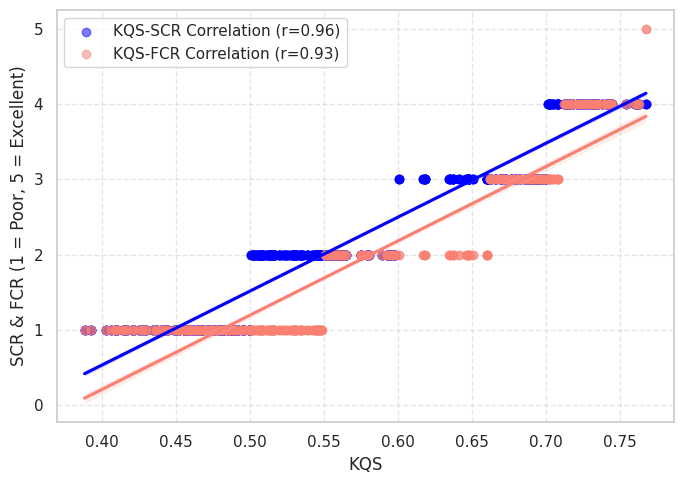

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation values
scr_corr = student_df["Final_KQS"].corr(student_df["Clarity_Rating_1_to_5"])
fcr_corr = faculty_df["Final_KQS"].corr(faculty_df["Clarity_Rating_1_to_5"])
print(f"🔗 Student KQS-SCR Correlation: {scr_corr:.3f}")
print(f"🔗 Faculty KQS-FCR Correlation: {fcr_corr:.3f}")

# Combined Scatter Plot
plt.figure(figsize=(7, 5))

# Students: Blue
sns.regplot(x="Final_KQS", y="Clarity_Rating_1_to_5", data=student_df,
            scatter_kws={'alpha': 0.5, 'color': 'blue'},
            line_kws={'color': 'blue'}, label=f"KQS-SCR Correlation (r={scr_corr:.2f})")

# Faculty: Green
sns.regplot(x="Final_KQS", y="Clarity_Rating_1_to_5", data=faculty_df,
            scatter_kws={'alpha': 0.5, 'color': 'salmon'},
            line_kws={'color': 'salmon'}, label=f"KQS-FCR Correlation (r={fcr_corr:.2f})")

# Labels and formatting
plt.xlabel("KQS")
plt.ylabel("SCR & FCR (1 = Poor, 5 = Excellent)")
#plt.title("KQS vs Clarity Ratings: Students & Faculty")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()




=== FACULTY FEEDBACK STATISTICS ===
         Faculty_ID  Lecture_id   Final_KQS Understandable  \
count           600  600.000000  600.000000            600   
unique          600         NaN         NaN              2   
top     Faculty_328         NaN         NaN             No   
freq              1         NaN         NaN            432   
mean            NaN  149.533333    0.567323            NaN   
std             NaN   86.618629    0.102837            NaN   
min             NaN    1.000000    0.388046            NaN   
25%             NaN   74.750000    0.484084            NaN   
50%             NaN  149.500000    0.542885            NaN   
75%             NaN  224.250000    0.671580            NaN   
max             NaN  299.000000    0.767267            NaN   

        Clarity_Rating_1_to_5 Objective_Aligned Trust_System  \
count              600.000000               600          600   
unique                    NaN                 3            3   
top                       

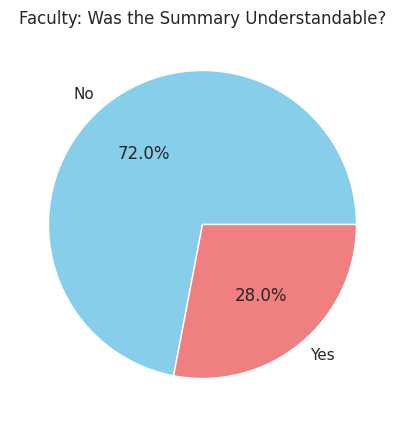

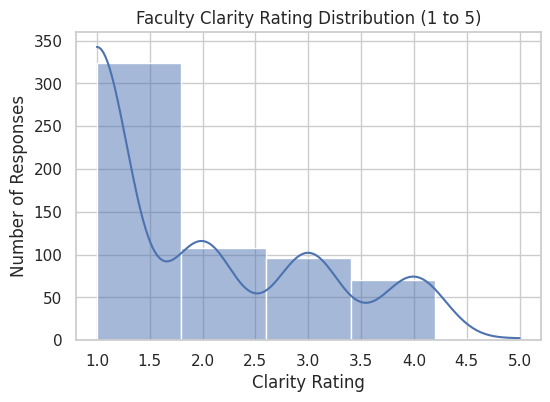

In [ ]:
# ========== FACULTY FEEDBACK SUMMARY ==========

print("\n=== FACULTY FEEDBACK STATISTICS ===")
print(faculty_df.describe(include='all'))

# Pie chart: Was Summary Understandable (Faculty)
plt.figure(figsize=(5,5))
faculty_df["Understandable"].value_counts().plot.pie(autopct='%1.1f%%', colors=["skyblue", "lightcoral"])
plt.title("Faculty: Was the Summary Understandable?")
plt.ylabel("")
plt.show()

# Histogram: Faculty Clarity Rating
plt.figure(figsize=(6,4))
sns.histplot(faculty_df["Clarity_Rating_1_to_5"], bins=5, kde=True)
plt.title("Faculty Clarity Rating Distribution (1 to 5)")
plt.xlabel("Clarity Rating")
plt.ylabel("Number of Responses")
plt.show()


#feedback Summary analytics

=== STUDENT PARTICIPATION ===
Total Feedback Entries: 1500
Unique Student IDs: 1495

Student Clarity Rating Distribution:
Clarity_Rating_1_to_5
1    480
2    505
3    280
4    235
Name: count, dtype: int64


/tmp/ipython-input-44-1556159466.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Clarity_Rating_1_to_5', data=student_df, palette="Blues")


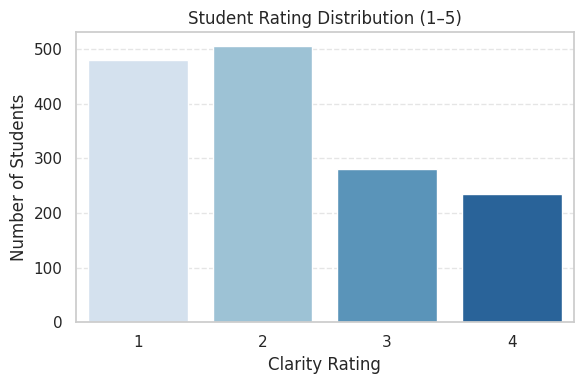


=== FACULTY PARTICIPATION ===
Total Feedback Entries: 600
Unique Faculty IDs: 600

Faculty Clarity Rating Distribution:
Clarity_Rating_1_to_5
1    324
2    108
3     96
4     70
5      2
Name: count, dtype: int64


/tmp/ipython-input-44-1556159466.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Clarity_Rating_1_to_5', data=faculty_df, palette="Greens")


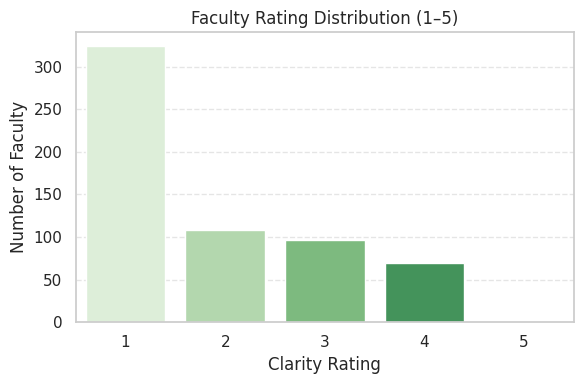

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load feedback files (update paths if needed)
student_df = pd.read_excel("/content/Student_Feedback_Objective_Aligned.xlsx")
faculty_df = pd.read_excel("/content/Faculty_Feedback_Objective_Alignment.xlsx")

# ---- STUDENT FEEDBACK STATS ----
print("=== STUDENT PARTICIPATION ===")
print(f"Total Feedback Entries: {len(student_df)}")
print(f"Unique Student IDs: {student_df['Student_ID'].nunique()}")
print("\nStudent Clarity Rating Distribution:")
print(student_df['Clarity_Rating_1_to_5'].value_counts().sort_index())

# Plot student clarity rating distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Clarity_Rating_1_to_5', data=student_df, palette="Blues")
plt.title("Student Rating Distribution (1–5)")
plt.xlabel("Clarity Rating")
plt.ylabel("Number of Students")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ---- FACULTY FEEDBACK STATS ----
print("\n=== FACULTY PARTICIPATION ===")
print(f"Total Feedback Entries: {len(faculty_df)}")
print(f"Unique Faculty IDs: {faculty_df['Faculty_ID'].nunique()}")
print("\nFaculty Clarity Rating Distribution:")
print(faculty_df['Clarity_Rating_1_to_5'].value_counts().sort_index())

# Plot faculty clarity rating distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Clarity_Rating_1_to_5', data=faculty_df, palette="Greens")
plt.title("Faculty Rating Distribution (1–5)")
plt.xlabel("Clarity Rating")
plt.ylabel("Number of Faculty")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
